In [2]:
import scipy
import jax
import jax.numpy as jnp
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

import cvxpy as cvx

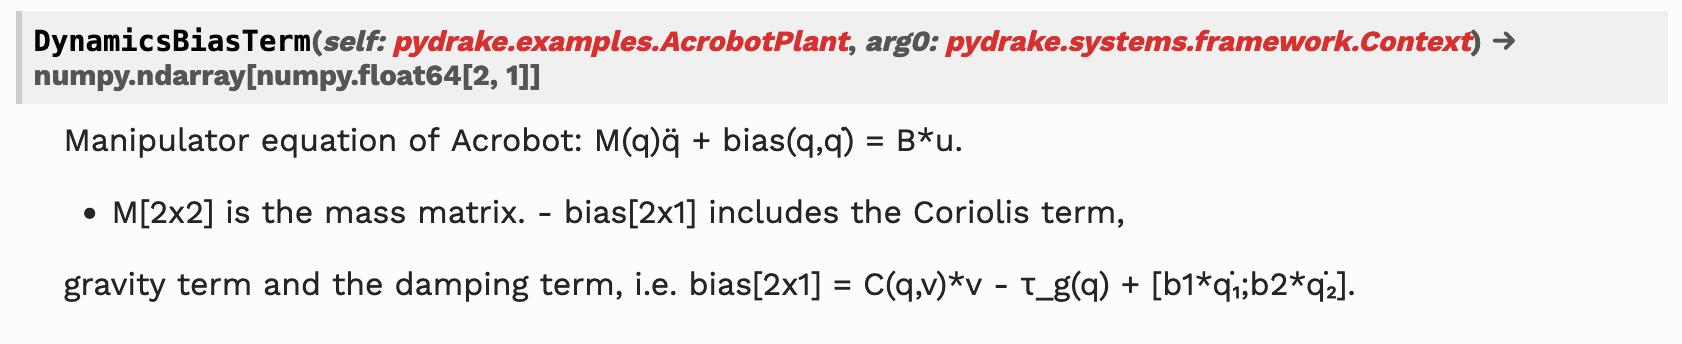

In [3]:
# Initiate the parameter like these
# https://drake.mit.edu/pydrake/pydrake.examples.html#pydrake.examples.AcrobotParams
m1 = 1
l1 = 1
lc1 = l1/2
Ic1 = 0.083
b1 = 0

m2 = 1
l2 = 2
lc2 = l2/2
Ic2 = 0.083
b2 = 0

g = 9.81

c = lambda θ: jnp.cos(θ)
s = lambda θ: jnp.sin(θ)

# def unpack_x(x):
#     # θ1, θ2, dθ1, dθ2 = x.flatten()
#     # θ1  = x[0]
#     # θ2  = x[1]
#     # dθ1 = x[2]
#     # dθ2 = x[3]
#     return x #θ1, θ2, dθ1, dθ2
    

def M(x):
    # PyDrake Implementation
    # https://github.com/RobotLocomotion/drake/blob/07cfb12aeb657595a9865dc205448d85302a5b86/examples/acrobot/acrobot_plant.cc#L55
    θ1, θ2, dθ1, dθ2 = x #unpack_x(x)
    I1 = Ic1 + m1 * lc1 * lc1;
    I2 = Ic2 + m2 * lc2 * lc2;
    m12 = I2 + m2*l1*lc2*c(θ2)
    return jnp.array(
        [
            [I1 + I2 + m2*l1**2 + 2*m2*l1*lc2*c(θ2), m12],
            [m12, I2 ]
         ]
    )

def C(x):
    θ1, θ2, dθ1, dθ2 = x #unpack_x(x)
    m2l1lc2 = m2*l1*lc2
    return jnp.array(
        [
            [-2*m2l1lc2*s(θ2)*dθ2, -m2l1lc2*s(θ2)*dθ2],
            [m2l1lc2*s(θ2)*dθ1, 0 ]
         ]
    )

D = jnp.array([[b1, 0],[0, b2]])

def τ_g(x):
    θ1, θ2, dθ1, dθ2 = x #unpack_x(x)
    return jnp.array(
        [
            [-m1*g*lc1*s(θ1) - m2*g*(l1*s(θ1)+lc2*s(θ1+θ2))],
            [-m2*g*lc2*s(θ1+θ2)]
         ]
    )


def bias(x):
    θ1, θ2, dθ1, dθ2 = x #unpack_x(x)
    return (
        (C(x)+ D) @ jnp.array([[dθ1],[dθ2]]) - τ_g(x)
    )
    
B = jnp.array([[0],[1]])

Ω = lambda x: jnp.block([
    [jnp.eye(2), 0*jnp.eye(2)],
    [C(x)+D, M(x)]
])

def dynamics(x, u): #ivp always expect t to be the first argument
    θ1, θ2, dθ1, dθ2 = x #unpack_x(x)
    # return (
    #     np.linalg.inv(Ω(x)) @ np.block([dθ1,
    #                                     dθ2,
    #                                     (τ_g(x) + B * u).flatten()
    #                                    ])
    # )
    return jnp.block([dθ1,
                    dθ2,
                    (jnp.linalg.inv(M(x)) @ (B*u - bias(x))).flatten()
                   ])


def M_pm(x):
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return jnp.array(
        [
            [(m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*c(θ2), m2*l2**2 + m2*l1*l2*c(θ2)],
            [m2*l2**2 + m2*l1*l1*c(θ2), m2*l2**2 ]
         ]
    )

def C_pm(x):
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return jnp.array(
        [
            [0, -m2*l1*l2*s(θ2)*(2*dθ1+dθ2)],
            [m2*l1*l2*s(θ2)*dθ1, 0 ]
         ]
    )

Ω_pm = lambda x: np.block([
    [np.eye(2), 0*np.eye(2)],
    [C_pm(x)+D, M_pm(x)]
])

def dynamics_point_mass(t, x, u=0): #ivp always expect t to be the first argument
    θ1, θ2, dθ1, dθ2 = unpack_x(x)
    return (
        np.linalg.inv(Ω_pm(x)) @ np.block([dθ1,
                                        dθ2,
                                        -g * ((m1+m2)*l1*s(θ1) + m2*l2*s(θ1+θ2)),
                                        -g * (m2*l2*s(θ1+θ2)) + u
                                       ])
    )


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
s(np.pi/2)

Array(1., dtype=float32, weak_type=True)

In [5]:
x0 = np.array([np.pi/2,np.pi/2,0,0])

T = 10                                  # simulation time
dt = 0.1
t = np.arange(0., T, dt)

N = t.size - 1

x = np.zeros((N + 1, 4))
x[0,:] = x0

t_span = (0,dt)

for i, tk in enumerate(t[:-1]):

    sol = integrate.solve_ivp(lambda t, x, u: dynamics(x, u), t_span, x[i,:], args=(0,))
    # break
    if not sol.success:
        print(tk, 'failed to solve')
        break
    x[i+1,:] = sol.y[:,-1]

In [6]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.803e-02  1.000e-01]
        y: [[ 5.862e+00  5.619e+00  5.315e+00]
            [-8.063e-01 -6.666e-01 -3.769e-01]
            [-4.638e+00 -5.433e+00 -6.293e+00]
            [ 1.652e+00  4.167e+00  6.993e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 14
     njev: 0
      nlu: 0

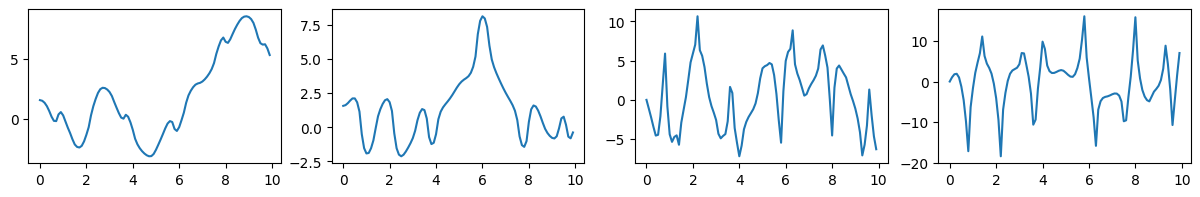

In [7]:
n = len(x0)

fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(t,x[:,i])

In [79]:
## Convert Theta to Position
pos_x_elbow = l1*s(x[:,0]) 
pos_y_elbow = -l1*c(x[:,0]) 

pos_x_end = pos_x_elbow+l2*s(x[:,0]+x[:,1]) 
pos_y_end = pos_y_elbow-l2*c(x[:,0]+x[:,1]) 

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation

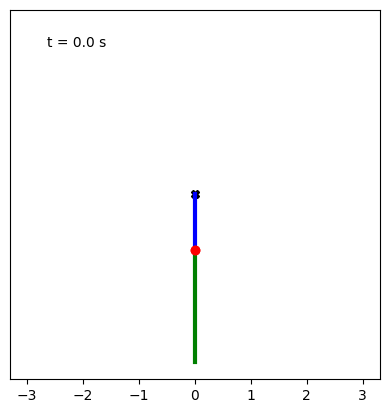

In [81]:
# Figure and axis
fig, ax = plt.subplots(dpi=100)
x_min, x_max, y_min, y_max = -1.1 * (l1+l2), 1.1 * (l1+l2), -1.1 * (l1+l2), 1.1 * (l1+l2)
ax.plot(0.0, 0.0, "X", linewidth=0.1, color="k")#[0]
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_yticks([])
ax.set_aspect(1.0)

# Artists
link1 = ax.plot([], [], "-", linewidth=3, color="b")[0]
link2 = ax.plot([], [], "-", linewidth=3, color="g")[0]
elbow = ax.plot([], [], "ro", linewidth=3)[0]
trace = ax.plot([], [], "--", linewidth=2, color="tab:orange")[0]
timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

def animate(k, t):
    # Geometry
    link1.set_data([0, pos_x_elbow[k]], [0, pos_y_elbow[k]])
    link2.set_data([pos_x_elbow[k], pos_x_end[k]], [pos_y_elbow[k], pos_y_end[k]])
    elbow.set_data([pos_x_elbow[k], pos_x_elbow[k]], [pos_y_elbow[k],pos_y_elbow[k]])
    trace.set_data(pos_x_end[:k], pos_y_end[:k])

    # Time-stamp
    timestamp.set_text("t = {:.1f} s".format(t[k]))

    artists = (link1, link2, elbow, trace, timestamp)
    return artists

ani = animation.FuncAnimation(
    fig, animate, t.size, fargs=(t,), interval=dt * 1000, blit=True
)

In [82]:
filename = 'test_scp'

ani.save(f"{filename}.mp4", writer="ffmpeg")
fig.savefig(f'./{filename}.png') 

### Swing-up SCP

In [72]:
def discretize(f, dt):
    """Discretize continuous-time dynamics `f` via Runge-Kutta integration."""

    def integrator(x, u, dt=dt):
        # print(s, u)
        k1 = dt * f(x, u)
        k2 = dt * f(x + k1 / 2, u)
        k3 = dt * f(x + k2 / 2, u)
        k4 = dt * f(x + k3, u)
        return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return integrator

def discrete_dynamics(x, u, dt=dt):

    x_next = x + dt * dynamics(x, u)
    return x_next

# def discrete_dynamics(x, u, dt=dt):
#     # dt = 0.1
#     # TODO: Fill in the Euler integrator below and return the next state

#     k1 = dt * dynamics(x, u)
#     k2 = dt * dynamics(x + k1 / 2, u)
#     k3 = dt * dynamics(x + k2 / 2, u)
#     k4 = dt * dynamics(x + k3, u)
#     return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [73]:
@partial(jax.jit, static_argnums=(0,))
@partial(jax.vmap, in_axes=(None, 0, 0))
def affinize(f, x, u):
    """Affinize the function `f(s, u)` around `(s, u)`.

    Arguments
    ---------
    f : callable
        A nonlinear function with call signature `f(s, u)`.
    s : numpy.ndarray
        The state (1-D).
    u : numpy.ndarray
        The control input (1-D).

    Returns
    -------
    A : jax.numpy.ndarray
        The Jacobian of `f` at `(s, u)`, with respect to `s`.
    B : jax.numpy.ndarray
        The Jacobian of `f` at `(s, u)`, with respect to `u`.
    c : jax.numpy.ndarray
        The offset term in the first-order Taylor expansion of `f` at `(s, u)`
        that sums all vector terms strictly dependent on the nominal point
        `(s, u)` alone.
    """
    # PART (b) ################################################################
    # INSTRUCTIONS: Use JAX to affinize `f` around `(s, u)` in two lines.

    # A is grad of f w.r.t. s
    # B is grad of f w.r.t. u
    # c is A*s + B*s + f(s,u)
    A, B = jax.jacrev(f, argnums=(0, 1))(x, u)

    # Check jacobian function usage

    c = -A @ x - B @ u + f(x, u)
    
    # raise NotImplementedError()
    # END PART (b) ############################################################
    return A, B, c

In [74]:
def scp_iteration(f, x0, x_goal, x_prev, u_prev, N, P, Q, R, u_max, ρ):
    """Solve a single SCP sub-problem for the cart-pole swing-up problem.

    Arguments
    ---------
    f : callable
        A function describing the discrete-time dynamics, such that
        `s[k+1] = f(s[k], u[k])`.
    s0 : numpy.ndarray
        The initial state (1-D).
    s_goal : numpy.ndarray
        The goal state (1-D).
    s_prev : numpy.ndarray
        The state trajectory around which the problem is convexified (2-D).
    u_prev : numpy.ndarray
        The control trajectory around which the problem is convexified (2-D).
    N : int
        The time horizon of the LQR cost function.
    P : numpy.ndarray
        The terminal state cost matrix (2-D).
    Q : numpy.ndarray
        The state stage cost matrix (2-D).
    R : numpy.ndarray
        The control stage cost matrix (2-D).
    u_max : float
        The bound defining the control set `[-u_max, u_max]`.
    ρ : float
        Trust region radius.

    Returns
    -------
    s : numpy.ndarray
        A 2-D array where `s[k]` is the open-loop state at time step `k`,
        for `k = 0, 1, ..., N-1`
    u : numpy.ndarray
        A 2-D array where `u[k]` is the open-loop state at time step `k`,
        for `k = 0, 1, ..., N-1`
    J : float
        The SCP sub-problem cost.
    """
    A, B, c = affinize(f, x_prev[:-1], u_prev)
    A, B, c = np.array(A), np.array(B), np.array(c)
    n = Q.shape[0]
    m = R.shape[0]
    x_cvx = cvx.Variable((N + 1, n)) # N is the total time steps; n is dimension of s_k
    u_cvx = cvx.Variable((N, m)) # N is the total time steps; m is dimension of u_k

    # PART (c) ################################################################
    # INSTRUCTIONS: Construct the convex SCP sub-problem.

    # objective 
        # 1. stage wise s cost 
        # 2. stage wise u cost
        # 3. stage wise s_final cost
    objective =  0
    objective +=  cvx.quad_form(x_cvx[-1,:]-x_goal, P) 

    for i in range(N):
        objective += cvx.quad_form(x_cvx[i,:]-x_goal, Q)

    for i in range(N):
        objective += cvx.quad_form(u_cvx[i,:], R)


        
    constraints = []

    constraints += [ x_cvx[0,:] == x0 ] # Constraint 1: initial starting state is s0
    # constraints += [ x_cvx[:,0] <= 2*np.pi ]
    # constraints += [ x_cvx[:,0] >= 2*np.pi ]
    # constraints += [ x_cvx[:,1] <= 2*np.pi ]
    # constraints += [ x_cvx[:,1] >= 2*np.pi ]
    # constraints += [ cvx.max(cvx.abs(u_cvx)) <= u_max] # Constraint 2: Control signals within a set of bounds [-u_max, u_max]

    # # Constraint 3: Trusted Region State
    # for i in range(N+1):
    #     for j in range(n):
    #         constraints += [cvx.abs(x_cvx[i,j] - x_prev[i,j])<= ρ]

    # # Constraint 4: Trusted Region Control
    # constraints += [cvx.abs(u_cvx[i] - u_prev[i])<= ρ for i in range(N)]
    
    # Constraint 5: Dynamics
    constraints += [ x_cvx[i+1,:] == A[i,:,:] @ x_cvx[i,:] + B[i,:,:] @ u_cvx[i,:] + c[i,:] for i in range(N)]
    
    # END PART (c) ############################################################

    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    prob.solve(verbose=False)
    if prob.status != "optimal":
        raise RuntimeError("SCP solve failed. Problem status: " + prob.status)
    x = x_cvx.value
    u = u_cvx.value
    # breakpoint()
    J = prob.objective.value
    return x, u, J

In [75]:
# Define constants
n = 4  # state dimension
m = 1  # control dimension
x0 = np.array([0.0, 0.0, 0.0, 0.0])  # initial state
x_goal = np.array([np.pi, 0, 0.0, 0.0])  # desired final state
T = 5  # total simulation time
dt = 0.1
t = np.arange(0.0, T + dt, dt)
N = t.size - 1
P = 1e5 * np.eye(n)  # terminal state cost matrix
Q = 1e2 * np.eye(n) #np.diag([1e-1, 1.0, 1e-3, 1e-3])  # state cost matrix
R = 10 * np.eye(m)  # control cost matrix
eps = 1e-3  # SCP convergence tolerance
ρ = 1.0  # trust region parameter
u_max = 20.0  # control effort bound
eps = 5e-1  # convergence tolerance
max_iters = 300  # maximum number of SCP iterations
animate = False  # flag for animation


# Initialize dynamically feasible nominal trajectories
u = np.zeros((N, m))
x = np.zeros((N + 1, n))
x[0] = x0
for k in range(N):
    x[k + 1] = discrete_dynamics(x[k], u[k])



# Do SCP until convergence or maximum number of iterations is reached
converged = False
J = np.zeros(max_iters + 1)
J[0] = np.inf
for i in (prog_bar := tqdm(range(max_iters))):
    x, u, J[i + 1] = scp_iteration(discrete_dynamics, x0, x_goal, x, u, N, P, Q, R,None, ρ)
    dJ = np.abs(J[i + 1] - J[i])
    prog_bar.set_postfix({"objective change": "{:.5f}".format(dJ)})
    if dJ < eps:
        converged = True
        print("SCP converged after {} iterations.".format(i))
        break
if not converged:
    print("SCP did not converge!")
J = J[1 : i + 1]

 51%|███████▌       | 152/300 [00:31<00:30,  4.87it/s, objective change=0.48904]

SCP converged after 152 iterations.


In [76]:
J

array([356777.31449769, 195792.17888632, 120130.97465197, 127113.16157546,
       135546.72781518, 118914.97947634, 115871.48349353, 112904.60637051,
       110972.66756166, 109267.74936957, 108069.44725913, 106948.52695608,
       106056.5074939 , 105237.15453606, 104549.87177529, 103938.22631129,
       103405.78283509, 102919.65208396, 102489.69766771, 102101.10765876,
       101749.48010629, 101421.60417047, 101118.32848944, 100837.35415042,
       100578.7912545 , 100336.7565273 , 100107.6564405 ,  99888.2841204 ,
        99679.21460895,  99480.93616951,  99293.55556177,  99115.0668802 ,
        98943.22155617,  98775.85155818,  98612.60369444,  98453.87523257,
        98300.76155964,  98153.4562945 ,  98011.39784644,  97873.11047666,
        97737.28938944,  97602.99623291,  97470.5070674 ,  97340.44229688,
        97213.7419091 ,  97090.70182102,  96970.98750405,  96853.70065747,
        96737.90547873,  96622.7881523 ,  96508.33326742,  96394.98888174,
        96283.64431847,  

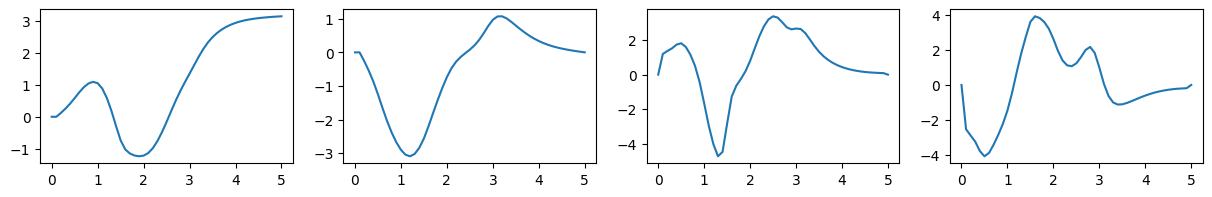

In [77]:
n = len(x0)

fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(t,x[:,i])

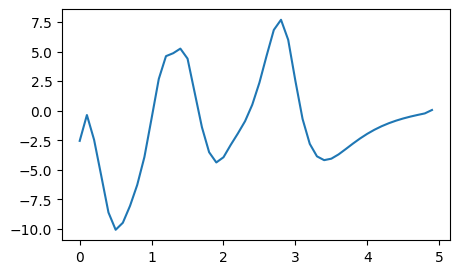

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t[:-1], u)

### What about LQR Solver

In [95]:
n_x = 4
n_u = 1

def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0] + 1, x0.shape[0]))
    # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
    x_trj[0] = x0
    for i, u in enumerate(u_trj):
        x_trj[i+1] = discrete_dynamics(x_trj[i], u)
    return x_trj


# Debug your implementation with this example code
N = 10
x0 = np.array([1, 0, 0, 1])
u_trj = np.zeros((N - 1, n_u))
x_trj = rollout(x0, u_trj)
x_trj

array([[ 1.        ,  0.        ,  0.        ,  1.        ],
       [ 0.94599694,  0.16477139, -1.02347672,  2.17416   ],
       [ 0.81183374,  0.39938211, -1.58127737,  2.34732866],
       [ 0.64237934,  0.60621661, -1.76297653,  1.69177127],
       [ 0.46740615,  0.72162944, -1.68891335,  0.53668845],
       [ 0.31719962,  0.69494051, -1.23313427, -1.18557262],
       [ 0.24248126,  0.45304036, -0.14160597, -3.84044385],
       [ 0.2934711 , -0.07672065,  0.71149558, -5.84665489],
       [ 0.27286363, -0.49121088, -1.2516737 , -2.15175462],
       [ 0.06272845, -0.53118128, -2.8649807 ,  1.2770195 ]])

In [131]:
α=1
@jax.jit
def cost_stage(x, u):
    return 1/2 * ((x-x_goal).T @ Q @ (x-x_goal) + u.T @ R @ u)


@jax.jit
def cost_stage(x, u):
    return jnp.sqrt((x-x_goal).T @ (x-x_goal)+α**2)-α + α**2*(jnp.cosh(u/α)-1)
    

@jax.jit
def cost_final(x):
    return 1/2 * ((x-x_goal).T @ P @ (x-x_goal))

@jax.jit
def cost_final(x):
    return jnp.sqrt((x-x_goal).T@(x-x_goal)+α**2)-α

In [132]:
@jax.jit
def cost_trj(x_trj, u_trj):
    total = 0.0
    # TODO: Sum up all costs
    total = (
        cost_final(x_trj[-1])+
        jnp.sum(jnp.array([cost_stage(x, u) for x, u in zip(x_trj[:-1], u_trj)]))
    )

    return total




# Debug your code
cost_trj(x_trj, u_trj)

Array(30.491444, dtype=float32)

In [133]:
@jax.jit
def deriv_stage(x, u, l=cost_stage):
    l_x = jax.jacrev(l, argnums=0)
    l_u = jax.jacrev(l, argnums=1)
    l_xx = jax.jacfwd(l_x, argnums=0)
    l_ux = jax.jacfwd(l_u, argnums=0)
    l_uu = jax.jacfwd(l_u, argnums=1)

    return l_x(x, u), l_u(x, u), l_xx(x, u), l_ux(x, u), l_uu(x, u)

@jax.jit
def deriv_final(x, l_final=cost_final):
    l_final_x = jax.jacrev(l_final, argnums=0)
    l_final_xx = jax.jacfwd(l_final_x, argnums=0)
    return l_final_x(x), l_final_xx(x)

@jax.jit
def deriv_dynamics(x, u, f=discrete_dynamics):
    f_x, f_u = jax.jacrev(f, argnums=(0, 1))(x, u)
    return f_x, f_u

x = np.array([0., 0., 0., 0.])
u = np.array([0.])
# print(deriv_stage(x, u))
print(cost_final(x), deriv_final(x))

2.2969084 (Array([-0.9528906,  0.       ,  0.       ,  0.       ], dtype=float32), Array([[0.02790483, 0.        , 0.        , 0.        ],
       [0.        , 0.30331448, 0.        , 0.        ],
       [0.        , 0.        , 0.30331448, 0.        ],
       [0.        , 0.        , 0.        , 0.30331448]], dtype=float32))


In [148]:
@jax.jit
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # TODO: Define the Q-terms here
    Q_x = l_x + V_x.T @ f_x #np.zeros(l_x.shape)
    Q_u = l_u + V_x.T @ f_u #np.zeros(l_u.shape)
    Q_xx = l_xx + f_x.T @ V_xx @ f_x #np.zeros(l_xx.shape)
    Q_ux = l_ux + f_u.T @ V_xx @ f_x #np.zeros(l_ux.shape)
    Q_uu = l_uu + f_u.T @ V_xx @ f_u #np.zeros(l_uu.shape)
    print(Q_x.shape, Q_u.shape, Q_xx.shape, Q_ux.shape, Q_uu.shape)
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

In [149]:
@jax.jit
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = jnp.linalg.inv(Q_uu)
    # TODO: Implement the feedforward gain k and feedback gain K.
    k = - Q_uu_inv @ Q_u.T  #np.zeros(Q_u.shape)
    K = - Q_uu_inv @ Q_ux #np.zeros(Q_ux.shape)
    return k, K

In [150]:
@jax.jit
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
    V_x = Q_x + K.T @ Q_u + k.T @ Q_ux + K.T @ Q_uu @ k #np.zeros(Q_x.shape)
    # print(Q_xx.shape, Q_ux.T.shape, K.shape, K.T.shape, Q_ux.shape, K.shape)  #np.zeros(Q_xx.shape)
    V_xx = Q_xx + 2 * Q_ux.T @ K + K.T @ Q_uu @ K  #np.zeros(Q_xx.shape) 
    
    return V_x, V_xx

In [151]:
@jax.jit
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T @ k - 0.5 * k.T @ Q_uu @ k

In [152]:
def forward_pass(x_trj, u_trj, k_trj, K_trj, fd=discrete_dynamics):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0, :] = x_trj[0, :]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
    for n in range(u_trj.shape[0]):
        # Note, converting from deviation variable to actual value variable
        u_trj_new[n,:] = u_trj[n,:] + k_trj[n,:] + K_trj[n,:] @ (x_trj_new[n,:]-x_trj[n,:])# Apply feedback law
        x_trj_new[n+1,:] = fd(x_trj_new[n,:], u_trj_new[n,:]) # Apply dynamics
    return x_trj_new, u_trj_new

In [153]:
def backward_pass(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # TODO: Set terminal boundary condition here (V_x, V_xx)
    V_x, V_xx = deriv_final(x_trj[-1])
    # print(V_x, V_xx)
    # print(x_trj.shape[1], u_trj.shape[1])
    # V_x = np.zeros((x_trj.shape[1],))
    # V_xx = np.zeros((x_trj.shape[1], x_trj.shape[1]))
    for n in range(u_trj.shape[0] - 1, -1, -1):
        # TODO: First compute derivatives, then the Q-terms
        l_x, l_u, l_xx, l_ux, l_uu = deriv_stage(x_trj[n], u_trj[n])
        f_x, f_u = deriv_dynamics(x_trj[n], u_trj[n])

        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)
        # print('Qx',Q_x,'Qu', Q_u, 'Qxx', Q_xx, 'Qux', Q_ux, 'Quu', Q_uu)
        # Q_x = np.zeros((x_trj.shape[1],))
        # Q_u = np.zeros((u_trj.shape[1],))
        # Q_xx = np.zeros((x_trj.shape[1], x_trj.shape[1]))
        # Q_ux = np.zeros((u_trj.shape[1], x_trj.shape[1]))
        # Q_uu = np.zeros((u_trj.shape[1], u_trj.shape[1]))
        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + jnp.eye(Q_uu.shape[0]) * regu
        # print(Q_uu_regu, Q_u, Q_ux)
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        k_trj[n, :] = k
        K_trj[n, :, :] = K
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        # print(Q_u, Q_uu, k)
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
    return k_trj, K_trj, expected_cost_redu

In [154]:
def run_ilqr(x0, N, max_iter=50, regu_init=100):
    np.random.seed(2)
    # First forward rollout
    u_trj = np.zeros((N - 1, n_u))#np.random.randn(N - 1, n_u) * 0.0001 # 
    x_trj = np.zeros((N, n_x))#rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01

    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]

    counter = 0

    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)
        

        print(counter, expected_cost_redu, total_cost, regu)
        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-10:
            break

        
        counter += 1
    return x_trj, u_trj, k_trj, K_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace


# Setup problem and call iLQR
x0 = jnp.array([0.0, 0.0, 0.0, 0.0])
T = 10
t = np.arange(0.0, T, 0.1)
N = len(t)
max_iter = 1000
regu_init = 0
x_trj, u_trj, k_trj, K_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(
    x0, N, max_iter, regu_init
)

(1, 4) (1, 1) (1, 4, 4) (1, 1, 4) (1, 1, 1)
(4, 1, 4) (4, 1, 1) (4, 4, 4) (4, 1, 4) (4, 1, 1)


TypeError: dot_general requires contracting dimensions to have the same shape, got (4,) and (1,).